In [101]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display as ipd
from sklearn.preprocessing import scale

### Prepared DataDrame

In [5]:
df = pd.read_csv('clean_track_info.csv',index_col=0)
df.head()

,track_fma_id,track_spot_id,time_signature,time_sig_confidence,tracks_id,track_name,artist_name,album_name,track_bit,track_top_genre
0,5,66381EvBZ6e3RXzYATpGmN,4,1.000,10,Freeway,Kurt Vile,Constant Hitmaker,192000,Pop
1,18,2ee4Do6eRNXGg7XqKGkvz3,3,1.000,141,Ohio,Alec K. Redfearn & the Eyesores,Every Man For Himself,128000,Folk
2,86,1OrbImTwzIVWtW1msIfa2r,4,0.815,213,Boute,Au,Au,256000,Pop
3,316,4ypiBQX6nsXTwLkaHwnaRI,4,0.349,534,I Can See You,Charles Manson,One Mind,128000,Folk
4,322,4m8jcQJ7wg4RyFNnIvZZgn,3,0.143,540,The Black Pirate,Charles Manson,One Mind,128000,Folk


### Collecting actual audio files for scraped data

In [ ]:
# df['tracks_id'] is the track ID for the audio clips in the fma small dataset

In [99]:
# getting filepaths for the tracks in the df
mp3_file_paths = []
for root, dirs, files in os.walk(r'C:\Users\Mendel Oster\data_science\fma_small\fma_small'):
    for file in files:
        if file.endswith(".mp3"):
            if int(file[:-4]) in list(df['tracks_id'].unique()):
                mp3_file_paths.append(os.path.join(root,file))

In [148]:
# copying the 1222 samples into new directory
for mp3 in mp3_file_paths:
    copy2(mp3, r'C:\Users\Mendel Oster\data_science\fma_small\all_tracks')

In [31]:
# for root, dirs, files in os.walk(r'C:\Users\Mendel Oster\data_science\fma_small\wav'):
#     for file in files:
#         dst = os.path.join(root,file[:-8]+'.wav')
#         src = os.path.join(root,file)
#         os.rename(src, dst)

In [32]:
wav_paths = []
for root, dirs, files in os.walk(r'C:\Users\Mendel Oster\data_science\fma_small\wav'):
    for file in files:
        wav_paths.append(os.path.join(root,file))

### Feature Engineering

1. First approach is to get the average of each MFCC vector and use that as the songs features

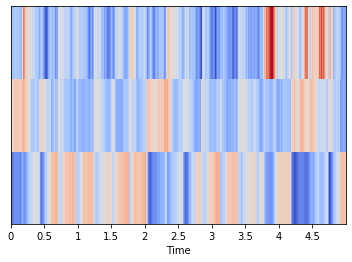

In [120]:
# Show what it looks like?? and explain this approach
librosa.display.specshow(scaled_mfcc[1:4,:430], sr=test_sr, x_axis='time')

In [277]:
def get_features(song_path, df):
    '''
    This function takes in a path to an audio and 
    1. converts it into a audio time series using librosa.load
    2. uses librosa.feature.mfcc to get the transformed coefficients
    3. computes the mean for each coef across time (axis=1 for computed mfcc) 
    4. retrievs the track id and time signature from the df
    5. returns a tuple (track_id, X, y) X, and y where Xi is each computed mean is and y is the class time signature 
    X.shape = (1,20) y.shape = (1,1)
    '''
    column_names = ['mfcc' + str(i) for i in range(1,21)]
    
#     audio time series, and audio sample rate
    A_y, A_sr = librosa.load(song_path)
#     compute mfcc features
    MFCCs = librosa.feature.mfcc(y=A_y, sr=A_sr)
    
#     computing mean and converting into DataFrame
    X = pd.DataFrame(MFCCs.mean(axis=1)).T
    X_cols = {old: new for old, new in zip(X.columns,column_names)}
    X.rename(columns=X_cols,inplace=True)
    
    track_id = int(song_path[-10:-4])
    y = df[df['tracks_id'] == track_id]['time_signature'].unique()[0]
    
    return (track_id, X, y)   

In [316]:
def preprocess(path_to_songs, df_with_time_sig):
    '''
    This function executes the 'get_features' function over all songs and returns a final DF ready for modeling
    '''
    track, xs, target = get_features(path_to_songs[0], df_with_time_sig)
    processed_df = pd.concat([pd.Series(track),xs, pd.Series(target)],axis=1)
    for i, song in enumerate(path_to_songs):
        t_id, X, y = get_features(song, df_with_time_sig)
        new_df = pd.concat([pd.Series(t_id), X, pd.Series(y)],axis=1)
        processed_df.loc[i] = new_df.loc[0]
    
    return processed_df.rename(columns={0: 'track_id', 1: 'time_signature'})

In [317]:
final_df = preprocess(wav_paths, df)

In [318]:
final_df.head()

,track_id,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,time_signature
0,10.0,-17.238174,94.442024,-48.614548,32.370766,-4.550584,2.220590,-2.271865,2.682117,-5.288854,...,2.239940,-6.416430,2.677109,-5.104513,-0.911098,-3.207996,3.043154,-1.036512,3.882601,4.0
1,141.0,-208.569260,116.633934,-1.723712,26.018599,9.688706,-4.179668,7.235491,-5.119752,-0.052033,...,-3.396803,-4.810870,3.130367,-2.126665,5.053833,-0.170090,3.087436,-8.665928,-1.098168,3.0
2,213.0,-264.020782,160.387070,0.499303,15.058126,12.012090,-8.957160,-10.785332,0.959413,-8.229311,...,-5.370893,-4.490613,-11.134265,-18.518158,-2.583431,-4.884125,1.371706,4.428988,-3.584380,4.0
3,534.0,-259.794342,150.240814,34.139011,54.562172,-13.361850,4.054343,11.771365,-16.188499,-5.989110,...,-4.746535,-8.018499,5.037824,-1.814148,0.693389,-1.805767,-3.202060,-3.180232,0.088710,4.0
4,540.0,-205.833633,137.933197,-4.343196,56.332245,-8.318016,-1.263402,12.592693,-10.305142,-17.365618,...,-1.929460,-11.026438,-0.828957,-10.977595,-1.921654,-6.113031,-1.286377,-0.227222,0.419077,3.0
